# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime as dt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import xgboost as xgb

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### check out what's wrong with column 18 and 19

In [4]:
azdias.iloc[:,18:20].describe()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
count,792242,792242
unique,19,43
top,8,51
freq,78023,77576


#### the reason for the error is the data type

In [6]:
set(azdias.CAMEO_DEUG_2015.apply(lambda x:type(x)))

{float, str}

In [7]:
set(azdias.CAMEO_INTL_2015.apply(lambda x:type(x)))

{float, str}

#### turns out the data are a fixed type of both string and floats

In [15]:
set(azdias.CAMEO_INTL_2015.dropna())

{'12',
 12.0,
 '13',
 13.0,
 '14',
 14.0,
 '15',
 15.0,
 '22',
 22.0,
 '23',
 23.0,
 '24',
 24.0,
 '25',
 25.0,
 '31',
 31.0,
 '32',
 32.0,
 '33',
 33.0,
 '34',
 34.0,
 '35',
 35.0,
 '41',
 41.0,
 '43',
 43.0,
 '44',
 44.0,
 '45',
 45.0,
 '51',
 51.0,
 '52',
 52.0,
 '54',
 54.0,
 '55',
 55.0,
 'XX'}

In [14]:
set(azdias.CAMEO_DEUG_2015.dropna())

{'1',
 1.0,
 '2',
 2.0,
 '3',
 3.0,
 '4',
 4.0,
 '5',
 5.0,
 '6',
 6.0,
 '7',
 7.0,
 '8',
 8.0,
 '9',
 9.0,
 'X'}

#### making the X and XX as mentioned in the feature file

In [3]:
azdias.loc[azdias.CAMEO_DEUG_2015=='X','CAMEO_DEUG_2015'] = -1
azdias.loc[azdias.CAMEO_INTL_2015=='XX','CAMEO_INTL_2015'] = -1

In [20]:
azdias[azdias.CAMEO_DEUG_2015==-1]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2511,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
4569,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
9803,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
16700,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
16883,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868148,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
874917,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
882189,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1
882231,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1


In [4]:
customers.loc[customers.CAMEO_DEUG_2015 == 'X','CAMEO_DEUG_2015'] = -1
customers.loc[customers.CAMEO_INTL_2015=='XX','CAMEO_INTL_2015'] = -1

In [5]:
customers[customers.CAMEO_INTL_2015==-1]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
2625,142366,1,5.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,3.0,NaN,9.0,1.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
3723,31812,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,6.0,NaN,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9970,48588,-1,9.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,6.0,NaN,9.0,2.0,1,COSMETIC,MULTI_BUYER,0,1,4
10233,139376,-1,5.0,0.0,8.0,10.0,NaN,NaN,NaN,1.0,...,4.0,1.0,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
11560,166652,-1,9.0,10.0,NaN,NaN,NaN,NaN,NaN,1.0,...,6.0,6.0,9.0,4.0,3,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178742,97987,1,5.0,13.0,NaN,NaN,NaN,NaN,13.0,0.0,...,2.0,NaN,9.0,2.0,1,FOOD,SINGLE_BUYER,0,1,3
178802,116305,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,1.0,...,1.0,6.0,9.0,1.0,1,COSMETIC,SINGLE_BUYER,0,1,4
183513,69256,2,1.0,7.0,NaN,NaN,NaN,NaN,7.0,1.0,...,6.0,6.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
184958,176568,2,6.0,8.0,NaN,NaN,NaN,NaN,8.0,3.0,...,7.0,6.0,3.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [6]:
def type_transfer(df,features):
    for f in features:
        df.loc[:,f] = df.loc[:,f].apply(lambda x:float(x))

In [7]:
type_transfer(azdias,['CAMEO_DEUG_2015','CAMEO_INTL_2015'])
type_transfer(customers,['CAMEO_DEUG_2015','CAMEO_INTL_2015'])


In [8]:
set(azdias.CAMEO_INTL_2015.apply(lambda x:type(x)))

{float}

### dealing with NA

In [9]:
azdias.dtypes[azdias.dtypes=='O']

CAMEO_DEU_2015              object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [90]:
len(azdias.CAMEO_DEU_2015.unique())

46

In [58]:
azdias.CAMEO_DEU_2015.describe()

count     792242
unique        45
top           6B
freq       56672
Name: CAMEO_DEU_2015, dtype: object

#### create percentage metrics for na values on features

In [28]:
azdias_null = azdias.isna().sum()
azdias_null_percent = azdias_null / len(azdias) * 100

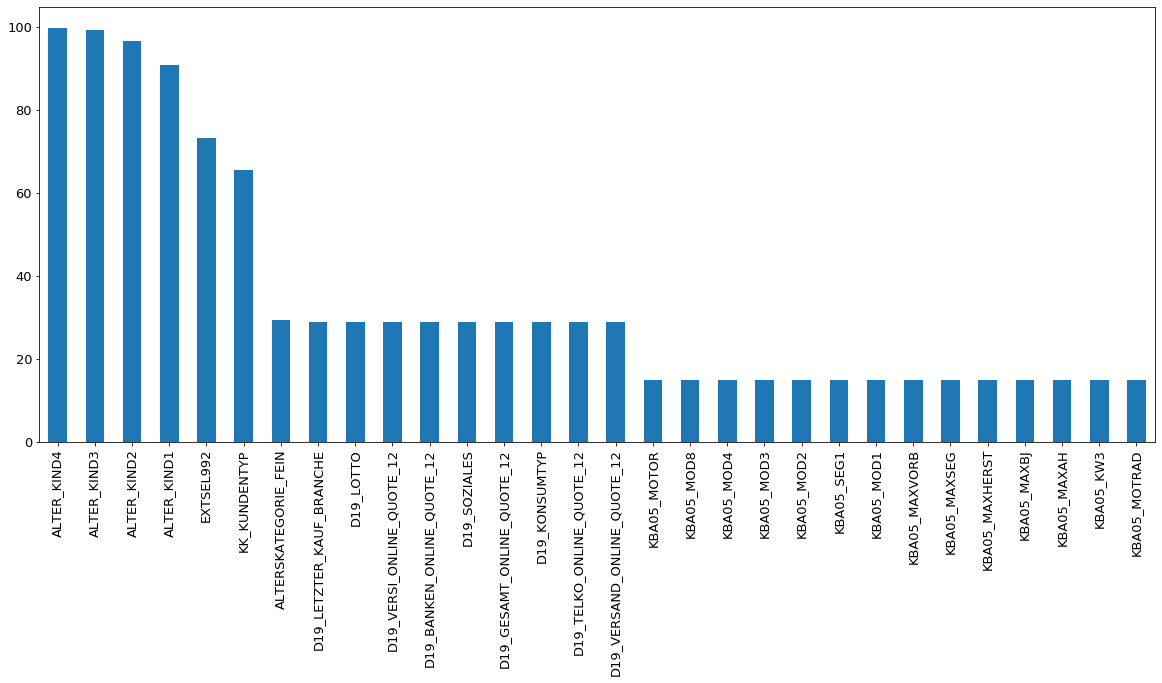

In [100]:
azdias_null_percent.sort_values(ascending=False)[:30].plot(kind='bar', figsize=(20,8), fontsize=13)

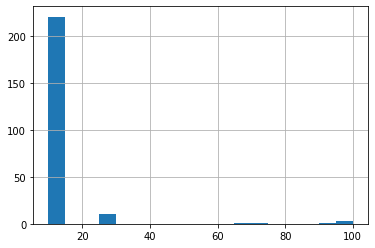

In [99]:
azdias_null_percent.hist( bins = np.linspace(10,100,19))

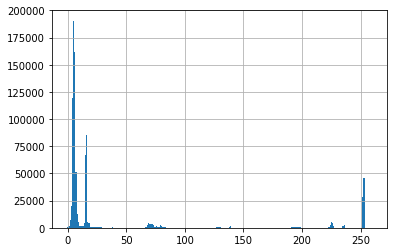

In [98]:
row_nans.hist(bins = np.arange(-0.5,row_nans.max()+1,1))

#### the top missing columns will be dropped as most of the features have much less na than those few columns

In [29]:
col_to_drop = azdias_null_percent.sort_values(ascending=False)[:6].index.to_numpy()

In [30]:
azdias.drop(col_to_drop,axis=1,inplace=True)


In [31]:
azdias.shape

(891221, 360)

In [32]:
customers.drop(set(customers.columns)-set(azdias.columns),axis=1,inplace=True)

In [33]:
customers.shape

(191652, 360)

In [114]:
azdias[azdias.KBA05_ALTER4 == 9].head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
52,507885,-1,3.0,19.0,19.0,10.0,0.0,0.0,1.0,11.0,...,4.0,2.0,3.0,4.0,6.0,4.0,4.0,4,2,1
72,577033,-1,9.0,0.0,NaN,36.0,1.0,0.0,1.0,36.0,...,3.0,10.0,12.0,9.0,6.0,9.0,1.0,3,2,4
73,577049,-1,1.0,15.0,15.0,16.0,0.0,0.0,1.0,14.0,...,2.0,8.0,11.0,10.0,3.0,4.0,7.0,6,2,3
158,876002,-1,9.0,0.0,NaN,67.0,0.0,0.0,1.0,67.0,...,2.0,10.0,10.0,7.0,0.0,9.0,1.0,4,1,3
274,696344,-1,1.0,17.0,16.0,6.0,0.0,1.0,2.0,6.0,...,0.0,4.0,7.0,7.0,1.0,8.0,7.0,4,1,4


In [34]:
feature = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx',header=1)

In [35]:
feature.drop('Unnamed: 0',axis=1,inplace=True)

In [36]:
feature.Attribute = feature.Attribute.ffill()

In [53]:
feature.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [55]:
feature[feature.Meaning.apply(lambda x:type(x) == float)]

,Attribute,Description,Value,Meaning
1906,LP_FAMILIE_GROB,NaN,4,NaN
1907,LP_FAMILIE_GROB,NaN,5,NaN
1909,LP_FAMILIE_GROB,NaN,7,NaN
1910,LP_FAMILIE_GROB,NaN,8,NaN
1912,LP_FAMILIE_GROB,NaN,10,NaN
1913,LP_FAMILIE_GROB,NaN,11,NaN
1977,LP_STATUS_GROB,NaN,2,NaN
1979,LP_STATUS_GROB,NaN,4,NaN
1980,LP_STATUS_GROB,NaN,5,NaN
1982,LP_STATUS_GROB,NaN,7,NaN


#### found unknown values to impuet na

In [57]:
feature[feature.Meaning.apply(lambda x:'unknown' in x.lower() if type(x)==str else False)]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [ ]:
unknown = feature[feature.Meaning.apply(lambda x:'unknown' in x.lower() if type(x)==str else False)]
unknown.loc[:,'value_list'] = unknown.Value.apply(lambda x:[int(item) for item in x.split(',')] if type(x) == str else [x])

In [20]:
unknown.head()

,Attribute,Description,Value,Meaning,value_list
0,AGER_TYP,best-ager typology,-1,unknown,[-1]
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
11,ALTER_HH,main age within the household,0,unknown / no main age detectable,[0]
33,ANREDE_KZ,gender,"-1, 0",unknown,"[-1, 0]"
40,BALLRAUM,distance to next urban centre,-1,unknown,[-1]


In [142]:
'BIP_FLAG' in set(unknown.Attribute)

True

#### create a unknown value dictionary to inpute later

#### for features who has two values in the excel file, I am trying to see which of the two values shows in the azdias file.
#### if not value is found, use -1 as -1 is used most in other features
#### if there's only one unknown, it will be out in the unknow list directly.

In [21]:
unknown_dic = {}
for i in range(unknown.shape[0]):
    attribute = unknown.Attribute.iloc[i]
    #print(i,attribute)
    values = unknown.value_list.iloc[i]
    if len(values) ==1:
        unknown_dic[attribute] = values[0]
    else:
        for value in values:
            if attribute in azdias.columns and value in azdias.loc[:,attribute].to_numpy():
                if attribute in unknown_dic:
                    print(attribute)
                else:
                    unknown_dic[attribute] = value

In [23]:
len(unknown)

233

In [36]:
len(unknown_dic.keys())

208

In [59]:
unknown.Attribute.apply(lambda x:x in (set(unknown.Attribute)-set(unknown_dic.keys()))&set(azdias.columns))

0       False
5        True
11      False
33       True
40      False
        ...  
2219     True
2229    False
2238    False
2244    False
2251     True
Name: Attribute, Length: 233, dtype: bool

In [60]:
unknown.loc[unknown.Attribute.apply(lambda x:x in (set(unknown.Attribute)-set(unknown_dic.keys()))&set(azdias.columns))]

,Attribute,Description,Value,Meaning,value_list
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
33,ANREDE_KZ,gender,"-1, 0",unknown,"[-1, 0]"
697,GEBAEUDETYP,type of building (residential or commercial),"-1, 0",unknown,"[-1, 0]"
749,HH_EINKOMMEN_SCORE,estimated household net income,"-1, 0",unknown,"[-1, 0]"
864,KBA05_GBZ,number of buildings in the microcell,"-1, 0",unknown,"[-1, 0]"
1025,KBA05_MODTEMP,development of the most common car segment in ...,"-1, 9",unknown,"[-1, 9]"
2090,SEMIO_DOM,affinity indicating in what way the person is ...,"-1, 9",unknown,"[-1, 9]"
2098,SEMIO_ERL,affinity indicating in what way the person is ...,"-1, 9",unknown,"[-1, 9]"
2106,SEMIO_FAM,affinity indicating in what way the person is ...,"-1, 9",unknown,"[-1, 9]"
2114,SEMIO_KAEM,affinity indicating in what way the person is ...,"-1, 9",unknown,"[-1, 9]"


#### most unknown is encoded as -1, so we will map others as -1

In [47]:
unknown_dic.values()

dict_values([-1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 9, 9, 9, 9, 9, -1, -1, -1, -1, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 9, 0, -1, -1, 0, -1, -1, 0])

In [62]:
for key in (set(unknown.Attribute)-set(unknown_dic.keys()))&set(azdias.columns):
    unknown_dic[key] = -1

In [25]:
(set(unknown.Attribute)-set(unknown_dic.keys()))&set(azdias.columns)

set()

In [67]:
unknown_dic

{'AGER_TYP': -1,
 'ALTER_HH': 0,
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_KK_KUNDENTYP': -1,
 'EWDICHTE': -1,
 'FINANZTYP': -1,
 'FINANZ_ANLEGER': -1,
 'FINANZ_HAUSBAUER': -1,
 'FINANZ_MINIMALIST': -1,
 'FINANZ_SPARER': -1,
 'FINANZ_UNAUFFAELLIGER': -1,
 'FINANZ_VORSORGER': -1,
 'HEALTH_TYP': -1,
 'INNENSTADT': -1,
 'KBA05_ALTER1': 9,
 'KBA05_ALTER2': 9,
 'KBA05_ALTER3': 9,
 'KBA05_ALTER4': 9,
 'KBA05_ANHANG': 9,
 'KBA05_ANTG1': -1,
 'KBA05_ANTG2': -1,
 'KBA05_ANTG3': -1,
 'KBA05_ANTG4': -1,
 'KBA05_AUTOQUOT': 9,
 'KBA05_BAUMAX': 0,
 'KBA05_CCM1': 9,
 'KBA05_CCM2': 9,
 'KBA05_CCM3': 9,
 'KBA05_CCM4': 9,
 'KBA05_DIESEL': 9,
 'KBA05_FRAU': 9,
 'KBA05_HERST1': 9,
 'KBA05_HERST2': 9,
 'KBA05_HERST3': 9,
 'KBA05_HERST4': 9,
 'KBA05_HERST5': 9,
 'KBA05_HERSTTEMP': 9,
 'KBA05_KRSAQUOT': 9,
 'KBA05_KRSHERST1': 9,
 'KBA05_KRSHERST2': 9,
 'KBA05_KRSHERST3': 9,
 'KBA05_KRSKLEIN': 9,
 'KBA05_KRSOBER': 9,
 'KBA05_KRSVAN': 9,
 'K

In [12]:
def save_obj(obj, name ):
    with open('data' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [77]:
save_obj(unknown_dic,'unknown_dic')

In [13]:
unknown_dic = load_obj('unknown_dic')

In [14]:
unknown_dic

{'AGER_TYP': -1,
 'ALTER_HH': 0,
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_KK_KUNDENTYP': -1,
 'EWDICHTE': -1,
 'FINANZTYP': -1,
 'FINANZ_ANLEGER': -1,
 'FINANZ_HAUSBAUER': -1,
 'FINANZ_MINIMALIST': -1,
 'FINANZ_SPARER': -1,
 'FINANZ_UNAUFFAELLIGER': -1,
 'FINANZ_VORSORGER': -1,
 'HEALTH_TYP': -1,
 'INNENSTADT': -1,
 'KBA05_ALTER1': 9,
 'KBA05_ALTER2': 9,
 'KBA05_ALTER3': 9,
 'KBA05_ALTER4': 9,
 'KBA05_ANHANG': 9,
 'KBA05_ANTG1': -1,
 'KBA05_ANTG2': -1,
 'KBA05_ANTG3': -1,
 'KBA05_ANTG4': -1,
 'KBA05_AUTOQUOT': 9,
 'KBA05_BAUMAX': 0,
 'KBA05_CCM1': 9,
 'KBA05_CCM2': 9,
 'KBA05_CCM3': 9,
 'KBA05_CCM4': 9,
 'KBA05_DIESEL': 9,
 'KBA05_FRAU': 9,
 'KBA05_HERST1': 9,
 'KBA05_HERST2': 9,
 'KBA05_HERST3': 9,
 'KBA05_HERST4': 9,
 'KBA05_HERST5': 9,
 'KBA05_HERSTTEMP': 9,
 'KBA05_KRSAQUOT': 9,
 'KBA05_KRSHERST1': 9,
 'KBA05_KRSHERST2': 9,
 'KBA05_KRSHERST3': 9,
 'KBA05_KRSKLEIN': 9,
 'KBA05_KRSOBER': 9,
 'KBA05_KRSVAN': 9,
 'K

#### inpute NA from unknown dic

In [86]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [79]:
'ALTER_HH' in unknown_dic

True

In [87]:
azdias.ALTER_HH#.fillna(value = unknown_dic)

0          NaN
1          0.0
2         17.0
3         13.0
4         20.0
          ... 
891216    17.0
891217    16.0
891218    17.0
891219     0.0
891220     0.0
Name: ALTER_HH, Length: 891221, dtype: float64

In [98]:
unknown_dic.get('AKT_DAT_KL')

In [102]:
azdias.loc[:,['AKT_DAT_KL','ALTER_HH']].fillna(value=unknown_dic).ALTER_HH.value_counts()

0.0     310267
18.0     60852
17.0     55665
19.0     52890
15.0     51867
16.0     51857
14.0     44275
21.0     41610
20.0     40671
13.0     37612
12.0     34923
10.0     30419
11.0     27924
9.0      22817
8.0      13463
7.0       8419
6.0       3809
5.0       1030
4.0        603
3.0        200
2.0         47
1.0          1
Name: ALTER_HH, dtype: int64

In [37]:
azdias_after_na = azdias.fillna(value = unknown_dic)

In [38]:
customers_after_na = customers.fillna(value= unknown_dic)

In [39]:
customers_after_na.shape

(191652, 360)

In [41]:
azdias_after_na.shape

(891221, 360)

#### there are features that's not in the features file but also having NAs, taking a look how many are there.

In [29]:
set(customers.columns[customers_after_na.isna().any()])&set(unknown_dic.keys())

set()

In [113]:
'AKT_DAT_KL' in set(unknown.Attribute)

False

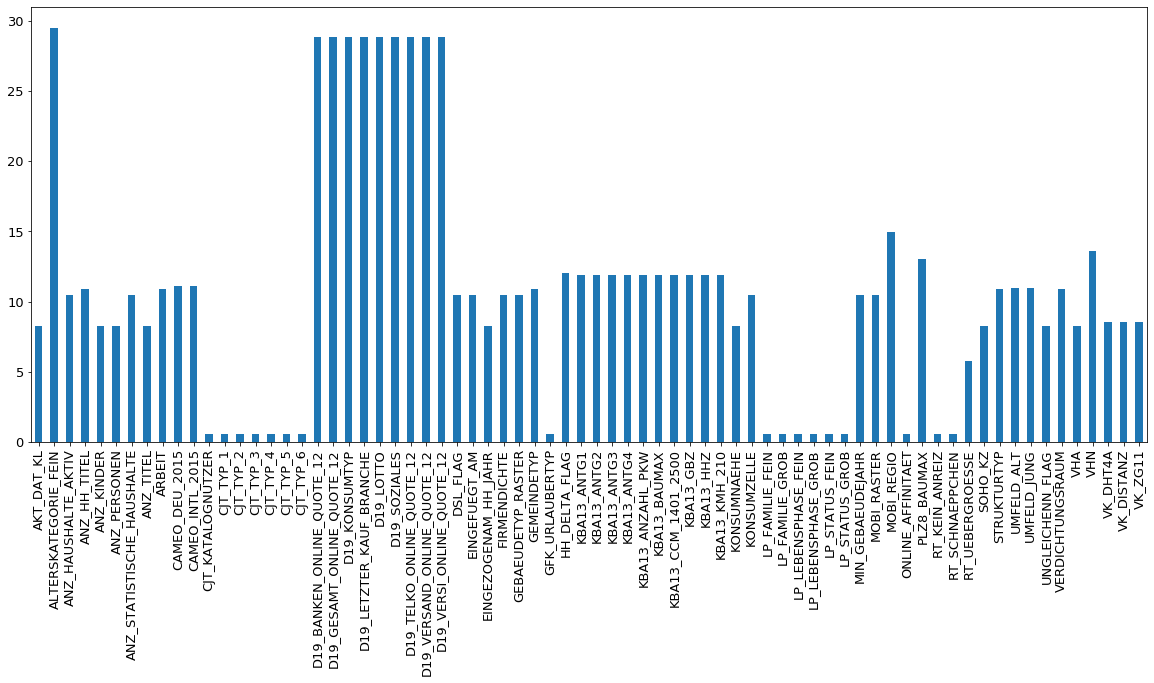

In [124]:
azdias_null_percent[customers.columns[customers_after_na.isna().any()]].plot(kind='bar', figsize=(20,8), fontsize=13)

#### most of the features are around 10% missing values. it's okay to not drop them and impute with -1

In [130]:
set( azdias_after_na.isna().any().index)-set(customers_after_na.isna().any().index )

set()

In [131]:
unknown_dic.get('AKT_DAT_KL')

In [132]:
azdias_after_na.fillna(-1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,3,1,2
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,0.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,17.0,15.0,0.0,0.0,1.0,11.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,16.0,11.0,0.0,0.0,1.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,17.0,3.0,0.0,0.0,0.0,3.0,...,2.0,7.0,10.0,8.0,0.0,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,20.0,7.0,0.0,1.0,1.0,5.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [133]:
azdias_after_na.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [144]:
feature[feature.Value.apply(lambda x:x==-1 )].Meaning.unique()#or '-1' in x if type(x) == list else False)]

array(['unknown'], dtype=object)

In [146]:
feature.Value

0       -1
1        0
2        1
3        2
4        3
        ..
2253     2
2254     3
2255     4
2256     5
2257     6
Name: Value, Length: 2258, dtype: object

In [158]:
customers_after_na_1 = customers_after_na.fillna(-1)

In [177]:
result = []
for col in customers_after_na_1.columns.to_list():
    result.append(sum(customers_after_na_1[col]==-1)/customers_after_na_1.shape[0])

In [182]:
np.where(np.array(result)>0.3)

(array([1], dtype=int64),)

#### only one column out of all the column that's larger than 30% NAs


#### transform categorical to numerical

In [31]:
customers_after_na.dtypes[customers_after_na.dtypes == 'O']

CAMEO_DEU_2015              object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [32]:
set(customers_after_na.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [33]:
customers_after_na.loc[:,customers_after_na.dtypes[customers_after_na.dtypes == 'O'].index].head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,NaN,D19_BANKEN_GROSS,NaN,-1
2,5D,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,4C,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,7B,D19_SCHUHE,1992-02-12 00:00:00,W


#### transform EINGEFUEGT_AM columns

In [18]:
def date_trans(df,col):
    df[col] = df[col].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') if type(x)==str else x)
    earliest = df[col].min()
    df[col] = df[col].apply(lambda x:(x-earliest).total_seconds() if type(x)!=float else x)
    #return df

In [42]:
#aa = customers_after_na.EINGEFUEGT_AM.copy().to_frame()
date_trans(customers_after_na,'EINGEFUEGT_AM')
#customers_after_na.EINGEFUEGT_AM = customers_after_na.EINGEFUEGT_AM#.head()
customers_after_na.EINGEFUEGT_AM.head()

0    172800.0
1         NaN
2         0.0
3         0.0
4    172800.0
Name: EINGEFUEGT_AM, dtype: float64

In [43]:
date_trans(azdias_after_na,'EINGEFUEGT_AM')
azdias_after_na.EINGEFUEGT_AM.head()

0            NaN
1     20563200.0
2     20736000.0
3    184464000.0
4     20736000.0
Name: EINGEFUEGT_AM, dtype: float64

In [44]:
azdias_after_na_dum = pd.get_dummies(azdias_after_na)
customers_after_na_dum = pd.get_dummies(customers_after_na)

In [45]:
customers_after_na_dum.shape

(191652, 440)

In [46]:
azdias_after_na_dum.shape

(891221, 440)

In [54]:
azdias_after_na.PRAEGENDE_JUGENDJAHRE.head()

0     0
1    14
2    15
3     8
4     8
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [47]:
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias_after_na_impute = imputer.fit_transform(azdias_after_na_dum)
azdias_after_na_impute = pd.DataFrame(azdias_after_na_impute)
print('imputed customer inpute: ', azdias_after_na_impute.head(5))

customers_after_na_impute = imputer.fit_transform(customers_after_na_dum)
customers_after_na_impute = pd.DataFrame(customers_after_na_impute)
print('imputed customers: ', customers_after_na_impute.head(5))

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


imputed customer inpute:          0    1    2     3     4     5    6    7    8     9    ...  430  431  \
0  910215.0 -1.0  1.0   0.0  15.0   1.0  0.0  0.0  1.0   1.0  ...  0.0  0.0   
1  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  12.0  ...  0.0  0.0   
2  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0   7.0  ...  0.0  0.0   
3  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0   2.0  ...  0.0  0.0   
4  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0   3.0  ...  0.0  0.0   

   432  433  434  435  436  437  438  439  
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 440 columns]
imputed customers:          0    1    2     3     4    5    6    7    8    9    ...  430  431  \
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  1.0  ...  0.0  0.0   
1    9628.0 -1.0  9.0  11.0  10.0  1.

In [48]:
customers_after_na_impute.to_pickle('customers_after_na_impute.pkl')

In [49]:
azdias_after_na_impute.to_pickle('azdias_after_na_impute.pkl')

In [53]:
sum(customers_after_na_impute.isna().any())

0

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [67]:
numercial_features = customers_after_na.dtypes[customers_after_na.dtypes!='O'].index.to_list()

In [69]:
correlated_col = calculate_vif_(customers_after_na_impute)

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-627d03df2a7c>", line 1, in <module>
    correlated_col = calculate_vif_(customers_after_na_impute)
  File "<ipython-input-57-9913b7658c2b>", line 9, in calculate_vif_
    for ix in range(X.iloc[:, variables].shape[1])]
  File "<ipython-input-57-9913b7658c2b>", line 9, in <listcomp>
    for ix in range(X.iloc[:, variables].shape[1])]
  File "C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py", line 184, in variance_inflation_factor
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
  File "C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py", line 838, in __init__
    hasconst=hasconst, **kwargs)
  File "C:\Users\xiaoyal\AppData\L

KeyboardInterrupt: 

In [73]:
scale = StandardScaler(copy=False)


azdias_scaled = scale.fit_transform(azdias_after_na_impute)
customers_scaled = scale.fit_transform(customers_after_na_impute)

In [55]:
azdias_after_na_impute.describe()

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
count,8.912210e+05,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.139722,9.968162,14.084059,7.525618,0.036222,0.141316,1.667629,6.909609,...,0.012872,0.002893,0.219180,0.029212,0.064781,0.039061,0.002428,0.104517,0.189117,0.706366
std,2.572735e+05,1.198724,3.610398,7.904590,4.306098,14.955945,0.306147,0.483089,1.125110,13.712002,...,0.112723,0.053706,0.413691,0.168399,0.246139,0.193740,0.049216,0.305931,0.391602,0.455427
min,1.916530e+05,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.372630e+05,-1.000000,1.000000,12.000000,15.000000,3.000000,0.000000,0.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,16.000000,9.000000,0.000000,0.000000,2.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.082873e+06,3.000000,9.000000,21.000000,25.000000,595.000000,23.000000,11.000000,45.000000,449.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

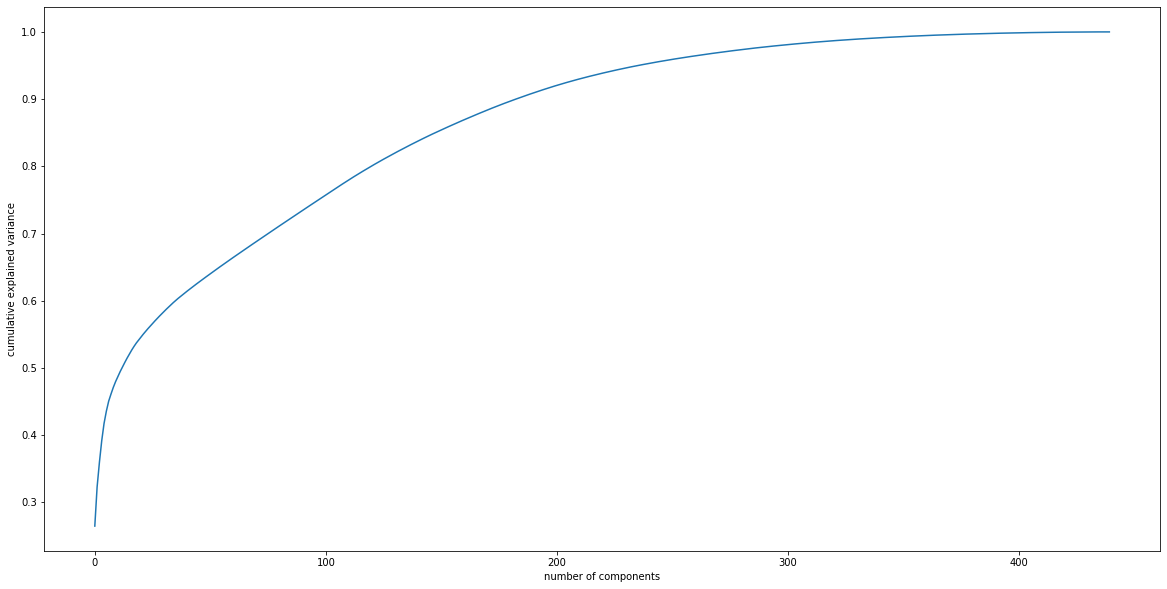

Wall time: 1min 22s


In [74]:

%%time
pca = PCA().fit(azdias_scaled)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### find what's made of the top components

In [175]:
np.square(pca.components_[0]).sum()

0.9999999999999998

In [206]:
import seaborn as sns

def plot_pca(vector_num,top_comp):
    v_1 = pca.components_[vector_num]
    comps = pd.DataFrame(list(zip(v_1, azdias_after_na_dum.columns.values)), 
                             columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(top_comp)
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(vector_num))
    plt.show()

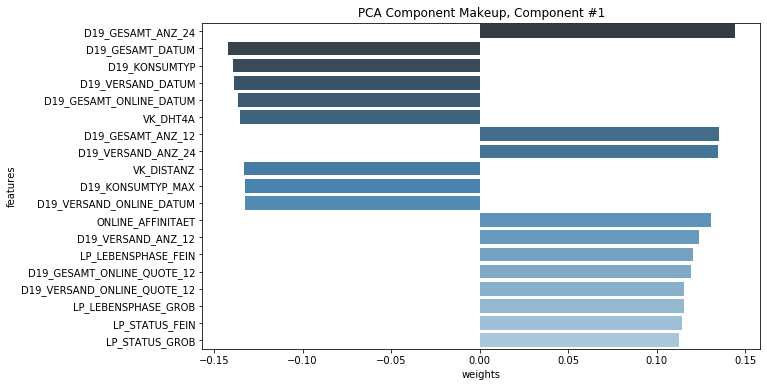

In [204]:
plot_pca(1,19)

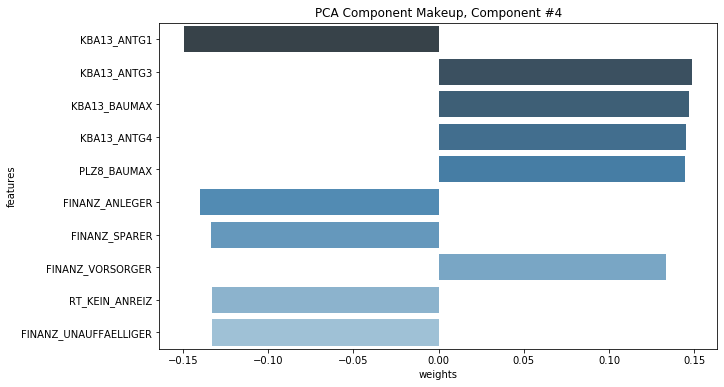

In [208]:
plot_pca(4,10)

#### dimention reduction

In [79]:

def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [81]:
reduced_azdias = reduce_data(azdias_scaled)
reduced_customers = reduce_data(customers_scaled)


0.9374140915725537
0.9567021895261978


In [89]:
customers_after_na_impute.columns#.LNR.head()

RangeIndex(start=0, stop=440, step=1)

In [96]:
def k_means_metric(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [95]:
model_k.score(azdias_scaled)

-256922730.80389813

RangeIndex(start=0, stop=220, step=1)

In [105]:
i

14

In [111]:
#metrics = pd.DataFrame({'Squared Error':np.array(metrics)})
metrics

,Squared Error
0,8.068412e+07
1,4.867516e+07
2,4.646039e+07
3,4.480409e+07
4,4.346813e+07
5,4.292179e+07
6,4.250639e+07
7,4.197662e+07
8,4.158531e+07
9,4.124017e+07


In [113]:
%%time

metrics = []
for i in range(14,21):
    metrics.append(k_means_metric(reduced_customers,i))
    print(i)
metrics = pd.DataFrame({'Squared Error':np.array(metrics)})

14
15
16
17
18
19
20
Wall time: 30min 43s


In [127]:
mm = [80684120.00,
48675160.00,
46460390.00,
44804090.00,
43468130.00,
42921790.00,
42506390.00,
41976620.00,
41585310.00,
41240170.00,
41002610.00,
40975130.00,
40560760.00]
for item in metrics.values:
    mm.append(item[0])

In [128]:
len(mm)

20

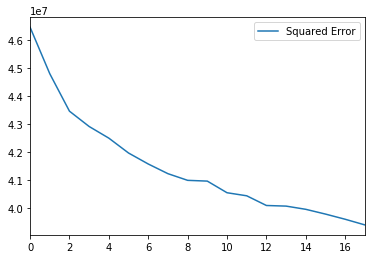

In [132]:
pd.DataFrame({'Squared Error':np.array(mm[2:])}).plot()

#### from the above elbow picture, we can see n = 10 should be picked 

In [133]:
%%time
kmeans_k = KMeans(10)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)
prediction_customers = model_k.predict(reduced_customers)


Wall time: 10min 38s


In [140]:
azdias_cluster = pd.DataFrame(prediction_azdias,columns = ['clusters'])
customers_cluster = pd.DataFrame(prediction_customers,columns = ['clusters'])


In [141]:
azdias_cluster.shape

(891221, 1)

In [147]:
av = azdias_cluster.clusters.value_counts()/azdias.shape[0]

In [149]:
cv = customers_cluster.clusters.value_counts()/customers.shape[0]

In [156]:
combined = pd.concat([av,cv],axis =1)
combined.columns = ['pop','cust']

In [157]:
combined

,pop,cust
0,0.137214,0.122143
1,0.034093,0.001941
2,0.160590,0.194749
3,0.083960,0.214754
4,0.097668,0.076388
5,0.157472,0.066209
6,0.034758,0.049157
7,0.127820,0.116164
8,0.146515,0.157457
9,0.019911,0.001038


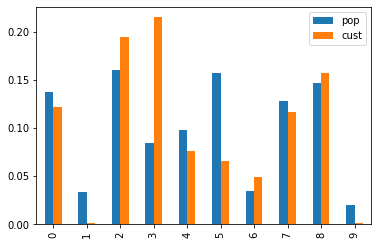

In [158]:
combined.plot(kind='bar')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [210]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [217]:
set(mailout_train.iloc[:,18].apply(lambda x:type(x)))

{float, str}

In [219]:
mailout_train.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [224]:
mailout_train[mailout_train.CAMEO_DEUG_2015.apply(lambda x:type(x)==str)].CAMEO_DEUG_2015

10240    4
10241    6
10242    2
10243    9
10244    8
        ..
40955    5
40956    5
40957    9
40958    8
40959    6
Name: CAMEO_DEUG_2015, Length: 10016, dtype: object

In [221]:
mailout_train.loc[mailout_train.CAMEO_DEUG_2015=='X','CAMEO_DEUG_2015'] = -1.0
mailout_train.loc[mailout_train.CAMEO_INTL_2015=='XX','CAMEO_INTL_2015'] = -1.0


In [226]:
mailout_train.CAMEO_DEUG_2015 = mailout_train.CAMEO_DEUG_2015.apply(lambda x:float(x))
mailout_train.CAMEO_INTL_2015 = mailout_train.CAMEO_INTL_2015.apply(lambda x:float(x))


In [227]:
set(mailout_train.iloc[:,18].apply(lambda x:type(x)))

{float}

In [228]:
mailout_train_after_na = mailout_train.fillna(value=unknown_dic)

In [230]:
y=mailout_train_after_na.RESPONSE

In [242]:
mailout_train_after_na.drop(np.concatenate([col_to_drop,['RESPONSE']]),axis=1,inplace=True)

In [243]:
mailout_train_after_na.shape

(42962, 360)

In [247]:
#aa = customers_after_na.EINGEFUEGT_AM.copy().to_frame()
date_trans(mailout_train_after_na,'EINGEFUEGT_AM')
#customers_after_na.EINGEFUEGT_AM = customers_after_na.EINGEFUEGT_AM#.head()
mailout_train_after_na.EINGEFUEGT_AM.head()

0     14169600.0
1    180057600.0
2    117763200.0
3     14169600.0
4     14169600.0
Name: EINGEFUEGT_AM, dtype: float64

In [248]:
mailout_train_after_na_dum = pd.get_dummies(mailout_train_after_na)

In [249]:
mailout_train_after_na_impute = imputer.fit_transform(mailout_train_after_na_dum)
mailout_train_after_na_impute = pd.DataFrame(mailout_train_after_na_impute)
print('mailout customer inpute: ', mailout_train_after_na_impute.head(5))

mailout customer inpute:        0    1    2     3     4     5    6    7    8     9    ...  430  431  \
0  1763.0  2.0  1.0   8.0   8.0  15.0  0.0  0.0  1.0  13.0  ...  0.0  0.0   
1  1771.0  1.0  4.0  13.0  13.0   1.0  0.0  0.0  2.0   1.0  ...  0.0  0.0   
2  1776.0  1.0  1.0   9.0   7.0   0.0  0.0  0.0  0.0   1.0  ...  0.0  0.0   
3  1460.0  2.0  1.0   6.0   6.0   4.0  0.0  0.0  2.0   4.0  ...  0.0  0.0   
4  1783.0  2.0  1.0   9.0   9.0  53.0  0.0  0.0  1.0  44.0  ...  0.0  0.0   

   432  433  434  435  436  437  438  439  
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 440 columns]


In [250]:
mailout_train_after_na_impute.shape

(42962, 440)

In [251]:
azdias_after_na_impute.shape

(891221, 440)

In [258]:
mailout_scaled = scale.fit_transform(mailout_train_after_na_impute)


#### train validation split

In [332]:
X_train, X_val, y_train, y_val = train_test_split(mailout_scaled, y, 
                                                  stratify=y, test_size=0.2, random_state=1)


#### 5 folds cross validation

In [288]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=1)
skf.get_n_splits(X_train, y_train)

5

In [289]:
print(skf)

StratifiedKFold(n_splits=5, random_state=1, shuffle=False)


In [291]:
for train_index, test_index in skf.split(X_train, y_train):
        print(len(train_index),len(test_index))

27494 6875
27495 6874
27495 6874
27496 6873
27496 6873


In [292]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''    
    learner = learner.fit(X_train, y_train)

    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    roc = roc_auc_score(y_test, predictions_test)
    return roc

In [300]:
mailout_scaled[[1,2,3]]

array([[-1.65598655,  0.32350199,  1.59429314, ..., -0.47014007,
        -0.4941958 ,  0.77841891],
       [-1.65578476,  0.32350199, -0.27404835, ..., -0.47014007,
         2.02348948, -1.28465532],
       [-1.66853798,  1.03126247, -0.27404835, ..., -0.47014007,
        -0.4941958 ,  0.77841891]])

In [301]:

rf = RandomForestClassifier(random_state=1,n_estimators=300)
xgb_ = xgb.XGBRegressor(random_state=1,n_estimators=300)


result_list = []
for model in [rf,xgb_]:
    model_name = model.__class__.__name__
    fold = 0
    for train_index, val_index in skf.split(mailout_scaled, y):    
        fold += 1
        print('Fold {}...'.format(fold))
        result = {}  
        result['model_name'] = model_name
        result['fold']  =  fold
        # Split the data into training and test sets
        X_train, X_val = mailout_scaled[train_index], mailout_scaled[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        
        
        result['roc'] = train_predict(model, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    

print('result_list: ', result_list)

Fold 1...
{'model_name': 'RandomForestClassifier', 'fold': 1, 'roc': 0.4995286353994815}
Fold 2...
{'model_name': 'RandomForestClassifier', 'fold': 2, 'roc': 0.4993518736742871}
Fold 3...
{'model_name': 'RandomForestClassifier', 'fold': 3, 'roc': 0.4985859061984445}
Fold 4...
{'model_name': 'RandomForestClassifier', 'fold': 4, 'roc': 0.4992929530992222}
Fold 5...
{'model_name': 'RandomForestClassifier', 'fold': 5, 'roc': 0.4993518736742871}
Fold 1...
{'model_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5380291012574863}
Fold 2...
{'model_name': 'XGBRegressor', 'fold': 2, 'roc': 0.6232552351206275}
Fold 3...
{'model_name': 'XGBRegressor', 'fold': 3, 'roc': 0.5818429021829519}
Fold 4...
{'model_name': 'XGBRegressor', 'fold': 4, 'roc': 0.5707936267948541}
Fold 5...
{'model_name': 'XGBRegressor', 'fold': 5, 'roc': 0.5925492153558136}
result_list:  [{'model_name': 'RandomForestClassifier', 'fold': 1, 'roc': 0.4995286353994815}, {'model_name': 'RandomForestClassifier', 'fold': 2, 'roc': 0.4993

In [306]:
parameters = {'max_depth': [3, 5, 7],
              'learning_rate':[0.01, 0.1],
              'min_child_weight': [1,3],
              'colsample_bytree':[0.5, 0.7],
              'reg_alpha':[0.01, 0.05],
              'n_estimators': [500,600],
              'objective' : ['binary:logistic']

             }
model = xgb.XGBClassifier()

# use grid rearch method to tune the hyper parameters
cv = GridSearchCV(model, parameters, scoring = 'roc_auc', n_jobs= -1)

grid_fit = cv.fit(X_train, y_train)



C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [312]:
grid_fit.best_params_, grid_fit.best_score_

best_model = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_model.predict(X_val)


In [320]:
X_val.shape

(8592, 440)

In [316]:
grid_fit.best_score_

0.7697658837622232

In [315]:
grid_fit.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 600,
 'objective': 'binary:logistic',
 'reg_alpha': 0.01}

In [369]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [277]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 500)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [317]:
preds = xg_reg.predict(X_val)
#preds = alg_test.predict(X_val)

In [333]:
preds2 = xg_reg.predict(X_val)
#preds = alg_test.predict(X_val)

In [ ]:
best_predictions = best_model.predict(X_val)


In [318]:
preds

array([0.01567923, 0.00489843, 0.0015338 , ..., 0.01952189, 0.00328638,
       0.00284877], dtype=float32)

In [273]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))


ROC score on validation data: 0.7135


In [319]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))


ROC score on validation data: 0.9078


In [331]:
preds2

array([0.01567923, 0.00489843, 0.0015338 , ..., 0.01952189, 0.00328638,
       0.00284877], dtype=float32)

In [334]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds2)))


ROC score on validation data: 0.7498


In [315]:
grid_fit.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 600,
 'objective': 'binary:logistic',
 'reg_alpha': 0.01}

In [367]:
save_obj(grid_fit.best_params_,'best_params')

In [323]:
best = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.7, learning_rate = 0.01,
                max_depth = 5,min_child_weight= 3, alpha = 10, n_estimators = 600,reg_alpha=1)
best.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [326]:
best_predictions = best.predict(X_val)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions)))


ROC score on validation data: 0.7579


In [335]:
best_predictions = best.predict(X_val)
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions)))


ROC score on validation data: 0.8629


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [302]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [359]:
mailout_test.loc[mailout_test.CAMEO_DEUG_2015=='X','CAMEO_DEUG_2015'] = -1.0
mailout_test.loc[mailout_test.CAMEO_INTL_2015=='XX','CAMEO_INTL_2015'] = -1.0
mailout_test.CAMEO_DEUG_2015 = mailout_test.CAMEO_DEUG_2015.apply(lambda x:float(x))
mailout_test.CAMEO_INTL_2015 = mailout_test.CAMEO_INTL_2015.apply(lambda x:float(x))
mailout_test_after_na = mailout_test.fillna(value=unknown_dic)
mailout_test_after_na.drop(col_to_drop,axis=1,inplace=True)
mailout_test_after_na = mailout_test_after_na.fillna(value=unknown_dic)
date_trans(mailout_test_after_na,'EINGEFUEGT_AM')
mailout_test_after_na_dum = pd.get_dummies(mailout_test_after_na)
mailout_test_after_na_dum.set_index('LNR')
mailout_test_after_na_impute = imputer.fit_transform(mailout_test_after_na_dum)
mailout_test_after_na_impute = pd.DataFrame(mailout_test_after_na_impute)

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [336]:
X_train.shape

(34369, 440)

In [349]:
mailout_test_after_na_impute.shape

(42833, 440)

In [339]:
mailout_test.shape

(42833, 366)

In [346]:
mailout_test_after_na_dum = pd.get_dummies(mailout_test_after_na)
mailout_test_after_na_impute = imputer.fit_transform(mailout_test_after_na_dum)
mailout_test_after_na_impute = pd.DataFrame(mailout_test_after_na_impute)

In [360]:
mailout_test_scaled = scale.fit_transform(mailout_test_after_na_impute)


In [355]:
test_result = best.predict(mailout_test_scaled)

In [356]:
mailout_test_scaled.shape

(42833, 440)

In [365]:
final_submit = pd.DataFrame({'Response':test_result})
final_submit.index = mailout_test.LNR

In [366]:
final_submit.head()

,Response
LNR,
1754,0.037558
1770,0.030495
1465,0.003967
1470,0.004608
1478,0.008679


In [370]:
final_submit.to_csv('final_submit.csv')

In [371]:
best

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [374]:
pickle.dump(model, open("pima.pickle.dat", "wb"))

In [375]:
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))